In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# A bunch of utility functions

def show_array_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')
    
def imgshow(array_image):
    """ Show one array image as uint8 and remove axis labels """
    sqrtimg = int(np.ceil(np.sqrt(array_image.shape[0])))
    imshow_noax(array_image.reshape([sqrtimg,sqrtimg]), normalize=True)

def array_to_image(array):
    sqrtimg = int(np.ceil(np.sqrt(array.shape[0])))
    x = np.array(array.reshape([sqrtimg,sqrtimg]))
    return x
    
def image_to_array(image):
    l = image.shape[0]*image.shape[1]
    x = np.array(image.reshape([l]))
    return x

def center_square(array_image, square_h, square_w, pixel_value = 0.45):
    img = array_to_image(array_image)
    h, w = img.shape                     
    j = int(round((h - square_h)/2.))
    i = int(round((w - square_w)/2.))
    img[j:j+square_h, i:i+square_w] = pixel_value
    img = image_to_array(img)
    return img

def mask_images(array_images, masktype, *args):
    """ Retruns an array of image and masked image pairs """
    masked_images = []
    for array_image in array_images:
        if masktype == 'square':
            masked = center_square(array_image,*args)
        masked_images.append(array_image)
        masked_images.append(masked)
    return np.array(masked_images)

#utility functions for GANs

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../data/MNIST', one_hot=False)

Extracting ../data/MNIST/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/t10k-labels-idx1-ubyte.gz


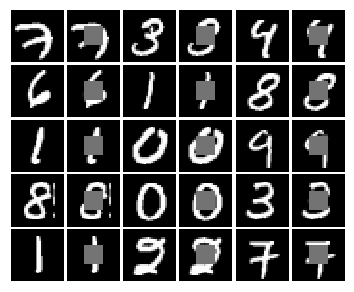

In [4]:
#Generating anomalies in images
masked_images = mask_images(mnist.train.images[0:15],'square',10,10)
show_array_images(masked_images)

(0.0, -1.0)


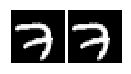

In [5]:
show = np.array([mnist.train.images[0],preprocess_img(mnist.train.images[0])])
show_array_images(show)                
print(np.min(mnist.train.images[0]), np.min(preprocess_img(mnist.train.images[0])))

In [6]:
#Restore a model
tf.reset_default_graph()
sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('../models/mnist_dcgan/mnist_dcgan.ckpt.meta')
saver.restore(sess,tf.train.latest_checkpoint('../models/mnist_dcgan/'))

INFO:tensorflow:Restoring parameters from ../models/mnist_dcgan/mnist_dcgan.ckpt


In [17]:
#Search inside ops
graph = tf.get_default_graph()
ops = graph.get_operations()


for op in ops:
   if 'generator/' in op.name:
      print(op.name)
#searching with name and shape!
#[print(op.name, op.outputs) for op in ops if 'random_uniform/' in op.name]
#op = graph.get_operation_by_name("random_uniform/mul")
#print(op.outputs)

generator/dense_0/kernel/Initializer/random_uniform/shape
generator/dense_0/kernel/Initializer/random_uniform/min
generator/dense_0/kernel/Initializer/random_uniform/max
generator/dense_0/kernel/Initializer/random_uniform/RandomUniform
generator/dense_0/kernel/Initializer/random_uniform/sub
generator/dense_0/kernel/Initializer/random_uniform/mul
generator/dense_0/kernel/Initializer/random_uniform
generator/dense_0/kernel
generator/dense_0/kernel/Assign
generator/dense_0/kernel/read
generator/dense_0/bias/Initializer/zeros
generator/dense_0/bias
generator/dense_0/bias/Assign
generator/dense_0/bias/read
generator/dense_0/MatMul
generator/dense_0/BiasAdd
generator/dense_0/Relu
generator/batchnorm_0/gamma/Initializer/ones
generator/batchnorm_0/gamma
generator/batchnorm_0/gamma/Assign
generator/batchnorm_0/gamma/read
generator/batchnorm_0/beta/Initializer/zeros
generator/batchnorm_0/beta
generator/batchnorm_0/beta/Assign
generator/batchnorm_0/beta/read
generator/batchnorm_0/moving_mean/Init

In [33]:
#Sample from generator
# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

graph = tf.get_default_graph()

#input of first operation we want to restore: generator = genertor input
gi = graph.get_tensor_by_name("random_uniform/mul:0")

#output of last operation we want to restore: discriminator = generator output
go = graph.get_tensor_by_name("generator/Reshape_1:0")
z = np.random.uniform(low=-1, high=1,size=(batch_size,noise_dim))
sample_out = sess.run(go, feed_dict={gi: z})

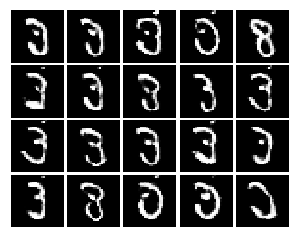

In [34]:
show_array_images(sample_out[0:20])

In [35]:
#Find discriminator loss
#[print(op.name, op.outputs,op) for op in ops if 'Mean' in op.name]

#for op in ops:
 #   if 'generator_loss' in op.name:
  #      print(op.name, op.outputs,op)
        

#generator loss
gl = graph.get_tensor_by_name("Mean_2:0")

In [36]:
#Adding new ops to the graph
image_shape = go.shape[1:].as_list()

alpha = 0.3

with graph.as_default():
    images = tf.placeholder(tf.float32,image_shape, name='images') 
    #define loss
    L2_loss = tf.nn.l2_loss(go-images)
    perceptual_loss = gl
    z_loss = L2_loss + 0.5*perceptual_loss
    z_grads = tf.gradients(z_loss, gi)

In [37]:
def z_search(z, x, real_x, nIter = 100, v = 0, momentum = 0.9, lr = 0.001, print_every = 10, show_every = 50):
    for i in range(nIter):
        out_vars = [z_loss, z_grads, go]
        in_dict = {gi: z, images: preprocess_img(x)}

        loss, grad, imout = sess.run(out_vars, feed_dict=in_dict)
        
        #print(x,imout[0])
        v_prev = np.copy(v)
        v = momentum*v - lr*grad[0]
        z += (-momentum * v_prev +
                   (1 + momentum) * v)
        z = np.clip(z, -1, 1)
        if (i % print_every == 0):
            print('Iteration {}: {}'.format(i, np.mean(loss)))

        if (i % show_every == 0):
            show = np.array([real_x,x,imout[0],imout[1]])
            show_array_images(show)
            plt.show()
    
    #final print
    print('Final images:')
    show = np.array([real_x,x,imout[0],imout[1]])
    show_array_images(show)
    plt.show()
    return imout

Iteration 0: 31573.234375


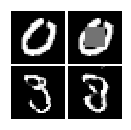

Iteration 500: 10658.4326172


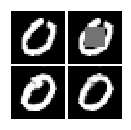

Iteration 1000: 8227.18945312


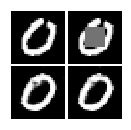

Iteration 1500: 7558.45117188


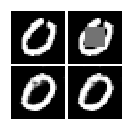

Final images:


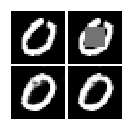

In [40]:
#Search in latent space
z = np.random.uniform(low=-1, high=1,size=(batch_size,noise_dim))

real_x = masked_images[14]
x = masked_images[15]

imout = z_search(z, x,real_x, nIter=2000, show_every=500, print_every=500, lr = 0.0001)

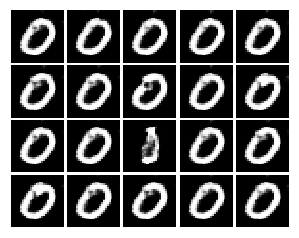

In [41]:
show_array_images(deprocess_img(imout[0:20]))